# 아래 경로의 폴더 안에 있는 파일들에 대해서 ML models 실험.
경로 : "/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data"

- labeling 기준 : eGFR < 60 기준 만을 사용. => tight3.csv 파일 사용.
- original vs under-sampling vs over-sampling
    - (basic) vs (food feature) vs (basic + food feature)
- SVM, RF, GBC

In [1]:
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import time

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, precision_score, accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_validate, StratifiedKFold

import xgboost as xgb

import os
import shap

import warnings
from sklearn.exceptions import ConvergenceWarning
import pickle
from joblib import dump, load

# ConvergenceWarning 경고를 무시
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# # set the seed
# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(seed)

# set_seed(1109)

#### functions

In [3]:
# test에 나머지 control sample 추가해서 idx 만 반환
def divide_testset(unbalanced_data, ratio):
    # train에서 ckd, control index 확인
    total_idx = unbalanced_data.index
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control
    # print(control_idx, ckd_idx)

    # ckd 갯수와 동일하게 control idx sampling
    rng = np.random.default_rng(seed=0) 
    sampled_ckd_idx = pd.Index(rng.choice(ckd_idx, size=int(len(ckd_idx)*ratio), replace=False))
    sampled_control_idx = pd.Index(rng.choice(control_idx, size=len(sampled_ckd_idx), replace=False)) # test_ckd 갯수와 동일하게 sampling
    
    test_idx = sampled_ckd_idx.append(sampled_control_idx)
    train_idx = total_idx.difference(test_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return unbalanced_data.loc[train_idx], unbalanced_data.loc[test_idx]

### Oversampling
def oversampling(unbalanced_dataframe, seed):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=seed)
    temp = unbalanced_dataframe.drop(['RID'], axis=1)
    X_train, y_train = smote.fit_resample(temp, temp['onset_tight'])

    # X_train에는 RID, onset_3 없음.
    return X_train.drop(['onset_tight'], axis=1), y_train

### Undersampling
# test에 나머지 control sample 추가해서 idx 만 반환
def _under_sampling_idx(unbalanced_data, seed):
    # train에서 ckd, control index 확인
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control
    # print(control_idx, ckd_idx)

    # ckd 갯수와 동일하게 control idx sampling
    """
    Control CKD 비율 조정
    """
    rng = np.random.default_rng(seed=seed) 
    sampled_control_idx = pd.Index(rng.choice(control_idx, size=len(ckd_idx), replace=False)) # ckd 갯수와 동일하게 sampling
    not_sampled_control_idx = control_idx.difference(sampled_control_idx)

    # 잘 sampling 되었는지 확인
    assert set(sampled_control_idx).issubset(set(control_idx))
    # print(len(sampled_control_idx))

    balanced_idx = sampled_control_idx.append(ckd_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return ckd_idx, sampled_control_idx, not_sampled_control_idx, balanced_idx

def undersampling(unbalanced_data, seed):
    a, b, c, d = _under_sampling_idx(unbalanced_data, seed)
    under_sampled_data = unbalanced_data.loc[d]
    X_undersampled = under_sampled_data.drop(['RID', 'onset_tight'], axis=1)
    y_undersampled = under_sampled_data['onset_tight']
    return X_undersampled, y_undersampled

def print_cv_results_ML(results_all_seed):
    # 모델별로 시드들의 평균과 표준편차를 구하는 부분
    results_summary = {}

    # 각 시드에 저장된 모델별 결과에 접근
    for seed in results_all_seed:
        for model_name in results_all_seed[seed]:
            if model_name not in results_summary:
                results_summary[model_name] = {
                    'recall': [],
                    'precision': [],
                    'accuracy': [],
                    'auc': [],
                    'recall_std': [],
                    'precision_std': [],
                    'accuracy_std': [],
                    'auc_std': []
                }
            # 각 시드의 성능 값을 추가
            results_summary[model_name]['recall'].append(results_all_seed[seed][model_name]['recall'][0])
            results_summary[model_name]['precision'].append(results_all_seed[seed][model_name]['precision'][0])
            results_summary[model_name]['accuracy'].append(results_all_seed[seed][model_name]['accuracy'][0])
            results_summary[model_name]['auc'].append(results_all_seed[seed][model_name]['auc'][0])
            results_summary[model_name]['recall_std'].append(results_all_seed[seed][model_name]['recall_std'][0])
            results_summary[model_name]['precision_std'].append(results_all_seed[seed][model_name]['precision_std'][0])
            results_summary[model_name]['accuracy_std'].append(results_all_seed[seed][model_name]['accuracy_std'][0])
            results_summary[model_name]['auc_std'].append(results_all_seed[seed][model_name]['auc_std'][0])

    # 모델별로 평균과 표준편차 계산
    for model_name in results_summary:
        print(f"Model: {model_name}")
        
        recall_mean = np.mean(results_summary[model_name]['recall'])
        recall_std = np.mean(results_summary[model_name]['recall_std'])
        
        precision_mean = np.mean(results_summary[model_name]['precision'])
        precision_std = np.mean(results_summary[model_name]['precision_std'])
        
        accuracy_mean = np.mean(results_summary[model_name]['accuracy'])
        accuracy_std = np.mean(results_summary[model_name]['accuracy_std'])
        
        auc_mean = np.mean(results_summary[model_name]['auc'])
        auc_std = np.mean(results_summary[model_name]['auc_std'])
        
        print(f"Recall Precision Accuracy AUC")
        print(f"{recall_mean:.4f}, {precision_mean:.4f}, {accuracy_mean:.4f}, {auc_mean:.4f}")
        print(f"{recall_std:.4f}, {precision_std:.4f}, {accuracy_std:.4f}, {auc_std:.4f}")    
        print("=" * 50)
        
def get_results(y_test, final_prediction, final_probabilities):
    cm = confusion_matrix(list(y_test), list(final_prediction))
    print(cm)
    tn, fn, tp, fp  = cm[0][0], cm[1][0], cm[1][1], cm[0][1]
    recall = tp / (fn + tp)
    precision = tp / (fp + tp)
    acc = (tp + tn) / (tn + fn + tp + fp)
    
    # Calculate AUC score
    auc = roc_auc_score(y_test, final_probabilities)
    
    print("Recall \t Precision \t Acc \t AUC")
    print(f"{np.round(recall, 4)} {np.round(precision, 4)} {np.round(acc, 4)} {np.round(auc, 4)}")
    
def model_fitting(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def model_eval(fitted_model, X_test, y_test):
    model_prediction = fitted_model.predict(X_test)
    model_probabilities = fitted_model.predict_proba(X_test)[:, 1]
    model_score = fitted_model.score(X_test, y_test)
    print(f"Score with simple {fitted_model} model")
    print(0.5, np.round(model_score, 4))     # accuracy

    get_results(y_test, model_prediction, model_probabilities)

# 1. Food mean

In [4]:
tight3_foodsum = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_basic_food_mean.csv")

In [5]:
tight3_foodsum_basic = tight3_foodsum[['RID', 'CT1_SEX', 'CT1_AGE', 'CT1_eGFR', 'imp_CT1_SBP', 'imp_CT1_BMI',
       'CT1_HB', 'Imp_CT1_ALBUMIN', 'CT1_TCHL', 'imp_new_EDU',
       'imp_new_INCOME', 'imp_new_DRINK', 'imp_new_SMOKE', 'new_CT1_gohyeol',
       'CT1_dangnyo', 'CT1_simhyeol', 'onset_tight']]
tight3_foodsum_food = tight3_foodsum[['RID', 'onset_tight', 'F01_Mean', 'F02_Mean', 'F03_Mean',
       'F04_Mean', 'F05_Mean', 'F06_Mean', 'F07_Mean', 'F08_Mean', 'F09_Mean',
       'F10_Mean', 'F11_Mean', 'F12_Mean', 'F13_Mean', 'F14_Mean', 'F15_Mean',
       'F16_Mean', 'F17_Mean', 'F18_Mean', 'F19_Mean', 'F20_Mean', 'F21_Mean']]

#### Food mean + Basic

##### Food + Basic Cross-validation

In [13]:
""" Total Dataset ( Food + Basic ) """

results_all_seed = {}

n_split = 10
for seed in [42, 59, 63, 79, 101]:    
    datas = {"original":(), "undersampling":(), "oversampling":()}

    # datas['undersampling'] = undersampling(tight3_foodsum.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
    results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        # X_test, y_test = datas['test']
        X_train, y_train = datas[data]
        
        wei_train_scaler = StandardScaler()
        X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        scoring = {
        'recall': 'recall_macro',      # recall for each class, then averaged
        'precision': 'precision_macro',# precision for each class, then averaged
        'accuracy': 'accuracy',        # accuracy
        'auc': make_scorer(roc_auc_score, multi_class='ovr')  # AUC 계산 (이진 분류시)
        }
        
        models = (
            # SVC(kernel='linear', random_state=seed, probability=True),
            # RandomForestClassifier(random_state=seed, max_depth=3),
            # LogisticRegression(max_iter=1000, random_state=seed),
            # GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
            GaussianNB(),
            # xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)
        )
        
        for i, model in enumerate(models):
            model_name = model.__class__.__name__  # 모델 이름 저장
            print("=" * 30)
            print(f"Cross Validation for {model} in fold {n_split}, with seed {seed}")
            # Stratified K-Fold 교차 검증 (K=5)
            skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
            results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)

            # 결과 출력
            print("각 폴드의 Recall:", results['test_recall'])
            print("각 폴드의 Precision:", results['test_precision'])
            print("각 폴드의 Accuracy:", results['test_accuracy'])
            print("각 폴드의 AUC:", results['test_auc'])

            # 결과 저장
            if model_name not in results_all_seed[seed]:
                results_all_seed[seed][model_name] = {
                    'recall': [], 
                    'precision': [], 
                    'accuracy': [], 
                    'auc': [],
                    'recall_std': [], 
                    'precision_std': [], 
                    'accuracy_std': [], 
                    'auc_std': []
                }
            results_all_seed[seed][model_name]['recall'].append(np.mean(results['test_recall']))
            results_all_seed[seed][model_name]['precision'].append(np.mean(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy'].append(np.mean(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc'].append(np.mean(results['test_auc']))
            results_all_seed[seed][model_name]['recall_std'].append(np.std(results['test_recall']))
            results_all_seed[seed][model_name]['precision_std'].append(np.std(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy_std'].append(np.std(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc_std'].append(np.std(results['test_auc']))
            
            
            # 평균값 계산
            print("평균 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.mean(results['test_recall']), 4)}, {round(np.mean(results['test_precision']),4)}, {round(np.mean(results['test_accuracy']), 4)}, {round(np.mean(results['test_auc']), 4)}")
            print("표준편차 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.std(results['test_recall']), 4)}, {round(np.std(results['test_precision']),4)}, {round(np.std(results['test_accuracy']), 4)}, {round(np.std(results['test_auc']), 4)}")
            print()
            
print_cv_results_ML(results_all_seed)

For undersampling dataset!!!
undersampling dataset loaded and scaled
X_train :: (1050, 36), y_train :: (1050,)
Cross Validation for GaussianNB() in fold 10, with seed 42
각 폴드의 Recall: [0.79082003 0.80043541 0.84796807 0.7808418  0.78102322 0.77122642
 0.87590711 0.82837446 0.72387518 0.83853411]
각 폴드의 Precision: [0.79209184 0.80263158 0.8494898  0.78104575 0.78102322 0.77181818
 0.87755102 0.82909091 0.72387518 0.84100877]
각 폴드의 Accuracy: [0.79047619 0.8        0.84761905 0.78095238 0.78095238 0.77142857
 0.87619048 0.82857143 0.72380952 0.83809524]
각 폴드의 AUC: [0.79082003 0.80043541 0.84796807 0.7808418  0.78102322 0.77122642
 0.87590711 0.82837446 0.72387518 0.83853411]
평균 Recall, Precision, Accuracy, AUC:
0.8039, 0.805, 0.8038, 0.8039
표준편차 Recall, Precision, Accuracy, AUC:
0.042, 0.0426, 0.042, 0.042

For undersampling dataset!!!
undersampling dataset loaded and scaled
X_train :: (1050, 36), y_train :: (1050,)
Cross Validation for GaussianNB() in fold 10, with seed 59
각 폴드의 Recall: [

##### Food + Basic Shap summary plot visualization

In [9]:
""" Apply shap value for each fold & SAVE"""

# seed = 59

# for seed in [42, 59, 63, 79, 101]:
for seed in [42]:
    # 저장 경로 설정
    dataset_name = "basic_foodmean_under"
    shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    # datas['undersampling'] = undersampling(tight3_foodsum.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]


    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    shap_values_all_models = {"SVC" : [],
                            "RandomForest" : [],
                            "LogisticRegression" : [],
                            "GradientBoosting" : [],
                            "XGBoost" : [],
                            }

    models = [
        ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),
        ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("XGBoost", xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed))
    ]

    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        for name, model in models:
            print(f"Training {name} model on fold {fold_num}...")
            model.fit(X_fold_train, y_fold_train)
            print(f"Model fitted!!")
            
            # SHAP Explainer 설정
            if name in ["RandomForest", "GradientBoosting", "XGBoost"]:
                explainer = shap.TreeExplainer(model)
            elif name == "SVC":
                explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_fold_train, 100))  # 샘플링하여 속도 향상
            elif name == "LogisticRegression":
                explainer = shap.LinearExplainer(model, X_fold_train)
            
            # SHAP 값 계산
            if name =="SVC":
                shap_values = explainer.shap_values(X_fold_test, silent=True)
            else:
                shap_values = explainer.shap_values(X_fold_test)
            shap_values_all_models[name].append(shap_values)
            
            # Summary plot 그리기 및 저장
            plt.figure()
            print(f"Plotting and saving SHAP Summary for {name} on fold {fold_num}...")

            save_path_model = os.path.join(shap_fig_dir, f"{model.__class__.__name__}")
            os.makedirs(save_path_model, exist_ok=True)
            save_path = os.path.join(save_path_model, f"summary_plot, model_{model.__class__.__name__}, fold_{fold_num}.png")

            # Summary plot 저장
            if name in ["SVC", "RandomForest"]:
                shap.summary_plot(shap_values[1], X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            else:
                shap.summary_plot(shap_values, X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            plt.title(f"Summary plot for {fold_num} fold of {model.__class__.__name__}")
            plt.savefig(save_path)
            plt.close()

    # 모든 fold가 끝난 후 shap_values_all_models 저장
    shap_values_save_path = os.path.join(shap_fig_dir, "shap_values_all_models.pk")

    # pickle을 사용하여 shap_values_all_models 저장
    with open(shap_values_save_path, 'wb') as f:
        pickle.dump(shap_values_all_models, f)

    print(f"All SHAP values saved to {shap_values_save_path}.")

Training SVC model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for SVC on fold 1...
Training RandomForest model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for RandomForest on fold 1...
Training LogisticRegression model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for LogisticRegression on fold 1...
Training GradientBoosting model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for GradientBoosting on fold 1...
Training SVC model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for SVC on fold 2...
Training RandomForest model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for RandomForest on fold 2...
Training LogisticRegression model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for LogisticRegression on fold 2...
Training GradientBoosting model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for GradientBoosting on fold 2...
Training SVC model on fold 3...
Model fitted

##### Other visualization for Food & Basic dataset.

In [ ]:
# """ Check feature importances for Tree-based Model"""

# # X_train, X_test, y_train, y_test = train_test_split(datas['undersampling'][0], datas['undersampling'][1], test_size=0.1, random_state=42)
# X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]

# # Tree-based 모델 훈련
# models = (RandomForestClassifier(random_state=42),
#           GradientBoostingClassifier(random_state=42, max_depth=3, learning_rate=0.01),
#           xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False))

# for rf in models:
#     rf.fit(X_train, y_train)

#     # 특성 중요도 계산
#     importances = rf.feature_importances_
#     indices = np.argsort(importances)[::-1]

#     # 특성 중요도 시각화
#     plt.figure(figsize=(10, 6))
#     plt.title(f"Feature importances by {rf.__class__.__name__}")
#     plt.bar(range(X_train.shape[1]), importances[indices], align="center")
#     plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
#     plt.show()

In [ ]:
# """ Total Dataset ( Food + Basic ) without eGFR """

# results_all_seed = {}

# n_split = 10
# for seed in [42, 59, 63, 79, 101]:    
#     datas = {"original":(), "undersampling":(), "oversampling":()}

#     datas['undersampling'] = undersampling(tight3_foodsum.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
#     datas['oversampling'] = oversampling(tight3_foodsum, seed=seed)
#     y_tight3_foodsum_train = tight3_foodsum['onset_tight']
#     X_tight3_foodsum_train = tight3_foodsum.drop(['RID', 'onset_tight', 'CT1_eGFR'], axis=1)
#     datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
#     results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
#     for data in ['undersampling']:
#         print(f"For {data} dataset!!!")
#         # X_test, y_test = datas['test']
#         X_train, y_train = datas[data]
        
#         wei_train_scaler = StandardScaler()
#         X_train = wei_train_scaler.fit_transform(X_train)
#         # X_test = wei_train_scaler.transform(X_test)
#         print(f"{data} dataset loaded and scaled")
#         print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
#         scoring = {
#         'recall': 'recall_macro',      # recall for each class, then averaged
#         'precision': 'precision_macro',# precision for each class, then averaged
#         'accuracy': 'accuracy',        # accuracy
#         'auc': make_scorer(roc_auc_score, multi_class='ovr')  # AUC 계산 (이진 분류시)
#         }
        
#         models = (
#             SVC(kernel='linear', random_state=seed, probability=True),
#             RandomForestClassifier(random_state=seed, max_depth=3),
#             LogisticRegression(max_iter=1000, random_state=seed),
#             GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
#             xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
#         )
        
#         for i, model in enumerate(models):
#             model_name = model.__class__.__name__  # 모델 이름 저장
#             print("=" * 30)
#             print(f"Cross Validation for {model} in fold {n_split}, with seed {seed}")
#             # Stratified K-Fold 교차 검증 (K=5)
#             skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
#             results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)

#             # 결과 출력
#             print("각 폴드의 Recall:", results['test_recall'])
#             print("각 폴드의 Precision:", results['test_precision'])
#             print("각 폴드의 Accuracy:", results['test_accuracy'])
#             print("각 폴드의 AUC:", results['test_auc'])

#             # 결과 저장
#             if model_name not in results_all_seed[seed]:
#                 results_all_seed[seed][model_name] = {
#                     'recall': [], 
#                     'precision': [], 
#                     'accuracy': [], 
#                     'auc': [],
#                     'recall_std': [], 
#                     'precision_std': [], 
#                     'accuracy_std': [], 
#                     'auc_std': []
#                 }
#             results_all_seed[seed][model_name]['recall'].append(np.mean(results['test_recall']))
#             results_all_seed[seed][model_name]['precision'].append(np.mean(results['test_precision']))
#             results_all_seed[seed][model_name]['accuracy'].append(np.mean(results['test_accuracy']))
#             results_all_seed[seed][model_name]['auc'].append(np.mean(results['test_auc']))
#             results_all_seed[seed][model_name]['recall_std'].append(np.std(results['test_recall']))
#             results_all_seed[seed][model_name]['precision_std'].append(np.std(results['test_precision']))
#             results_all_seed[seed][model_name]['accuracy_std'].append(np.std(results['test_accuracy']))
#             results_all_seed[seed][model_name]['auc_std'].append(np.std(results['test_auc']))
            
            
#             # 평균값 계산
#             print("평균 Recall, Precision, Accuracy, AUC:")
#             print(f"{round(np.mean(results['test_recall']), 4)}, {round(np.mean(results['test_precision']),4)}, {round(np.mean(results['test_accuracy']), 4)}, {round(np.mean(results['test_auc']), 4)}")
#             print("표준편차 Recall, Precision, Accuracy, AUC:")
#             print(f"{round(np.std(results['test_recall']), 4)}, {round(np.std(results['test_precision']),4)}, {round(np.std(results['test_accuracy']), 4)}, {round(np.std(results['test_auc']), 4)}")
#             print()
            
# print_cv_results_ML(results_all_seed)

In [ ]:
# """ Check feature importances """

# # X_train, X_test, y_train, y_test = train_test_split(datas['undersampling'][0], datas['undersampling'][1], test_size=0.1, random_state=42)
# X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]

# # Tree-based 모델 훈련
# models = (RandomForestClassifier(random_state=42),
#           GradientBoostingClassifier(random_state=42, max_depth=3, learning_rate=0.01),
#           xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False))

# for rf in models:
#     rf.fit(X_train, y_train)

#     # 특성 중요도 계산
#     importances = rf.feature_importances_
#     indices = np.argsort(importances)[::-1]

#     # 특성 중요도 시각화
#     plt.figure(figsize=(10, 6))
#     plt.title(f"Feature importances by {rf.__class__.__name__}")
#     plt.bar(range(X_train.shape[1]), importances[indices], align="center")
#     plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
#     plt.show()

#### Basic only from Food mean

##### Only Basic Cross-validation

In [ ]:
""" Only Basic dataset """

results_all_seed = {}

n_split = 10
for seed in [42, 59, 63, 79, 101]:    
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(tight3_foodsum_basic, seed=seed)
    datas['oversampling'] = oversampling(tight3_foodsum_basic, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_basic['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_basic.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
    results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        # X_test, y_test = datas['test']
        X_train, y_train = datas[data]
        
        wei_train_scaler = StandardScaler()
        X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        scoring = {
        'recall': 'recall_macro',      # recall for each class, then averaged
        'precision': 'precision_macro',# precision for each class, then averaged
        'accuracy': 'accuracy',        # accuracy
        'auc': make_scorer(roc_auc_score, multi_class='ovr')  # AUC 계산 (이진 분류시)
        }
        
        models = (
            SVC(kernel='linear', random_state=seed, probability=True),
            RandomForestClassifier(random_state=seed, max_depth=3),
            LogisticRegression(max_iter=1000, random_state=seed),
            GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
            # xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)
        )
        
        for i, model in enumerate(models):
            model_name = model.__class__.__name__  # 모델 이름 저장
            print("=" * 30)
            print(f"Cross Validation for {model} in fold {n_split}, with seed {seed}")
            # Stratified K-Fold 교차 검증 (K=5)
            skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
            results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)

            # 결과 출력
            print("각 폴드의 Recall:", results['test_recall'])
            print("각 폴드의 Precision:", results['test_precision'])
            print("각 폴드의 Accuracy:", results['test_accuracy'])
            print("각 폴드의 AUC:", results['test_auc'])

            # 결과 저장
            if model_name not in results_all_seed[seed]:
                results_all_seed[seed][model_name] = {
                    'recall': [], 
                    'precision': [], 
                    'accuracy': [], 
                    'auc': [],
                    'recall_std': [], 
                    'precision_std': [], 
                    'accuracy_std': [], 
                    'auc_std': []
                }
            results_all_seed[seed][model_name]['recall'].append(np.mean(results['test_recall']))
            results_all_seed[seed][model_name]['precision'].append(np.mean(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy'].append(np.mean(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc'].append(np.mean(results['test_auc']))
            results_all_seed[seed][model_name]['recall_std'].append(np.std(results['test_recall']))
            results_all_seed[seed][model_name]['precision_std'].append(np.std(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy_std'].append(np.std(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc_std'].append(np.std(results['test_auc']))
            
            
            # 평균값 계산
            print("평균 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.mean(results['test_recall']), 4)}, {round(np.mean(results['test_precision']),4)}, {round(np.mean(results['test_accuracy']), 4)}, {round(np.mean(results['test_auc']), 4)}")
            print("표준편차 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.std(results['test_recall']), 4)}, {round(np.std(results['test_precision']),4)}, {round(np.std(results['test_accuracy']), 4)}, {round(np.std(results['test_auc']), 4)}")
            print()
            
print_cv_results_ML(results_all_seed)

##### Only Basic Shap summary plot visualization

In [9]:
""" Apply shap value for each fold & SAVE"""

# seed = 59

# for seed in [42, 59, 63, 79, 101]:
for seed in [42]:
    # 저장 경로 설정
    dataset_name = "basic_only_under"
    shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    # datas['undersampling'] = undersampling(tight3_foodsum_basic.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum_basic, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum_basic, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_basic['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_basic.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]


    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    shap_values_all_models = {"SVC" : [],
                            "RandomForest" : [],
                            "LogisticRegression" : [],
                            "GradientBoosting" : [],
                            "XGBoost" : [],
                            }

    models = [
        ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),
        ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("XGBoost", xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed))
    ]

    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        for name, model in models:
            print(f"Training {name} model on fold {fold_num}...")
            model.fit(X_fold_train, y_fold_train)
            print(f"Model fitted!!")
            
            # SHAP Explainer 설정
            if name in ["RandomForest", "GradientBoosting", "XGBoost"]:
                explainer = shap.TreeExplainer(model)
            elif name == "SVC":
                explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_fold_train, 100))  # 샘플링하여 속도 향상
            elif name == "LogisticRegression":
                explainer = shap.LinearExplainer(model, X_fold_train)
            
            # SHAP 값 계산
            if name =="SVC":
                shap_values = explainer.shap_values(X_fold_test, silent=True)
            else:
                shap_values = explainer.shap_values(X_fold_test)
            shap_values_all_models[name].append(shap_values)
            
            # Summary plot 그리기 및 저장
            plt.figure()
            print(f"Plotting and saving SHAP Summary for {name} on fold {fold_num}...")

            save_path_model = os.path.join(shap_fig_dir, f"{model.__class__.__name__}")
            os.makedirs(save_path_model, exist_ok=True)
            save_path = os.path.join(save_path_model, f"summary_plot, model_{model.__class__.__name__}, fold_{fold_num}.png")

            # Summary plot 저장
            if name in ["SVC", "RandomForest"]:
                shap.summary_plot(shap_values[1], X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            else:
                shap.summary_plot(shap_values, X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            plt.title(f"Summary plot for {fold_num} fold of {model.__class__.__name__}")
            plt.savefig(save_path)
            plt.close()

    # 모든 fold가 끝난 후 shap_values_all_models 저장
    shap_values_save_path = os.path.join(shap_fig_dir, "shap_values_all_models.pk")

    # pickle을 사용하여 shap_values_all_models 저장
    with open(shap_values_save_path, 'wb') as f:
        pickle.dump(shap_values_all_models, f)

    print(f"All SHAP values saved to {shap_values_save_path}.")

Training SVC model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for SVC on fold 1...
Training RandomForest model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for RandomForest on fold 1...
Training LogisticRegression model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for LogisticRegression on fold 1...
Training GradientBoosting model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for GradientBoosting on fold 1...
Training SVC model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for SVC on fold 2...
Training RandomForest model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for RandomForest on fold 2...
Training LogisticRegression model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for LogisticRegression on fold 2...
Training GradientBoosting model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for GradientBoosting on fold 2...
Training SVC model on fold 3...
Model fitted

##### Other visualization for Only basic dataset

In [ ]:
# # X_train, X_test, y_train, y_test = train_test_split(datas['undersampling'][0], datas['undersampling'][1], test_size=0.1, random_state=42)
# X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]

# # Tree-based 모델 훈련
# models = (RandomForestClassifier(random_state=42),
#           GradientBoostingClassifier(random_state=42, max_depth=3, learning_rate=0.01),
#           xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False))

# for rf in models:
#     rf.fit(X_train, y_train)

#     # 특성 중요도 계산
#     importances = rf.feature_importances_
#     indices = np.argsort(importances)[::-1]

#     # 특성 중요도 시각화
#     plt.figure(figsize=(10, 6))
#     plt.title(f"Feature importances by {rf.__class__.__name__}")
#     plt.bar(range(X_train.shape[1]), importances[indices], align="center")
#     plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
#     plt.show()

#### Food mean only

##### Food mean Cross-validation

In [ ]:
""" Only Food dataset """

results_all_seed = {}

n_split = 10
for seed in [42, 59, 63, 79, 101]:    
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(tight3_foodsum_food, seed=seed)
    datas['oversampling'] = oversampling(tight3_foodsum_food, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_food['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_food.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
    results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        # X_test, y_test = datas['test']
        X_train, y_train = datas[data]
        
        wei_train_scaler = StandardScaler()
        X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        scoring = {
        'recall': 'recall_macro',      # recall for each class, then averaged
        'precision': 'precision_macro',# precision for each class, then averaged
        'accuracy': 'accuracy',        # accuracy
        'auc': make_scorer(roc_auc_score, multi_class='ovr')  # AUC 계산 (이진 분류시)
        }
        
        models = (
            SVC(kernel='linear', random_state=seed, probability=True),
            RandomForestClassifier(random_state=seed, max_depth=3),
            LogisticRegression(max_iter=1000, random_state=seed),
            GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
            # xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)
        )
        
        for i, model in enumerate(models):
            model_name = model.__class__.__name__  # 모델 이름 저장
            print("=" * 30)
            print(f"Cross Validation for {model} in fold {n_split}, with seed {seed}")
            # Stratified K-Fold 교차 검증 (K=5)
            skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
            results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)

            # 결과 출력
            print("각 폴드의 Recall:", results['test_recall'])
            print("각 폴드의 Precision:", results['test_precision'])
            print("각 폴드의 Accuracy:", results['test_accuracy'])
            print("각 폴드의 AUC:", results['test_auc'])

            # 결과 저장
            if model_name not in results_all_seed[seed]:
                results_all_seed[seed][model_name] = {
                    'recall': [], 
                    'precision': [], 
                    'accuracy': [], 
                    'auc': [],
                    'recall_std': [], 
                    'precision_std': [], 
                    'accuracy_std': [], 
                    'auc_std': []
                }
            results_all_seed[seed][model_name]['recall'].append(np.mean(results['test_recall']))
            results_all_seed[seed][model_name]['precision'].append(np.mean(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy'].append(np.mean(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc'].append(np.mean(results['test_auc']))
            results_all_seed[seed][model_name]['recall_std'].append(np.std(results['test_recall']))
            results_all_seed[seed][model_name]['precision_std'].append(np.std(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy_std'].append(np.std(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc_std'].append(np.std(results['test_auc']))
            
            
            # 평균값 계산
            print("평균 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.mean(results['test_recall']), 4)}, {round(np.mean(results['test_precision']),4)}, {round(np.mean(results['test_accuracy']), 4)}, {round(np.mean(results['test_auc']), 4)}")
            print("표준편차 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.std(results['test_recall']), 4)}, {round(np.std(results['test_precision']),4)}, {round(np.std(results['test_accuracy']), 4)}, {round(np.std(results['test_auc']), 4)}")
            print()
            
print_cv_results_ML(results_all_seed)

##### Food mean_only Shap summary plot visualziation

In [10]:
""" Apply shap value for each fold & SAVE"""

# seed = 59

# for seed in [42, 59, 63, 79, 101]:
for seed in [42]:
    # 저장 경로 설정
    dataset_name = "foodmean_only_under"
    shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    # datas['undersampling'] = undersampling(tight3_foodsum_food.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum_food, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum_food, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_food['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_food.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]


    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    shap_values_all_models = {"SVC" : [],
                            "RandomForest" : [],
                            "LogisticRegression" : [],
                            "GradientBoosting" : [],
                            "XGBoost" : [],
                            }

    models = [
        ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),
        ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("XGBoost", xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed))
    ]

    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        for name, model in models:
            print(f"Training {name} model on fold {fold_num}...")
            model.fit(X_fold_train, y_fold_train)
            print(f"Model fitted!!")
            
            # SHAP Explainer 설정
            if name in ["RandomForest", "GradientBoosting", "XGBoost"]:
                explainer = shap.TreeExplainer(model)
            elif name == "SVC":
                explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_fold_train, 100))  # 샘플링하여 속도 향상
            elif name == "LogisticRegression":
                explainer = shap.LinearExplainer(model, X_fold_train)
            
            # SHAP 값 계산
            if name =="SVC":
                shap_values = explainer.shap_values(X_fold_test, silent=True)
            else:
                shap_values = explainer.shap_values(X_fold_test)
            shap_values_all_models[name].append(shap_values)
            
            # Summary plot 그리기 및 저장
            plt.figure()
            print(f"Plotting and saving SHAP Summary for {name} on fold {fold_num}...")

            save_path_model = os.path.join(shap_fig_dir, f"{model.__class__.__name__}")
            os.makedirs(save_path_model, exist_ok=True)
            save_path = os.path.join(save_path_model, f"summary_plot, model_{model.__class__.__name__}, fold_{fold_num}.png")

            # Summary plot 저장
            if name in ["SVC", "RandomForest"]:
                shap.summary_plot(shap_values[1], X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            else:
                shap.summary_plot(shap_values, X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            plt.title(f"Summary plot for {fold_num} fold of {model.__class__.__name__}")
            plt.savefig(save_path)
            plt.close()

    # 모든 fold가 끝난 후 shap_values_all_models 저장
    shap_values_save_path = os.path.join(shap_fig_dir, "shap_values_all_models.pk")

    # pickle을 사용하여 shap_values_all_models 저장
    with open(shap_values_save_path, 'wb') as f:
        pickle.dump(shap_values_all_models, f)

    print(f"All SHAP values saved to {shap_values_save_path}.")

Training SVC model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for SVC on fold 1...
Training RandomForest model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for RandomForest on fold 1...
Training LogisticRegression model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for LogisticRegression on fold 1...
Training GradientBoosting model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for GradientBoosting on fold 1...
Training SVC model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for SVC on fold 2...
Training RandomForest model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for RandomForest on fold 2...
Training LogisticRegression model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for LogisticRegression on fold 2...
Training GradientBoosting model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for GradientBoosting on fold 2...
Training SVC model on fold 3...
Model fitted

##### Other visualization for Food mean_only dataset

In [ ]:
# # X_train, X_test, y_train, y_test = train_test_split(datas['undersampling'][0], datas['undersampling'][1], test_size=0.1, random_state=42)
# X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]

# # Tree-based 모델 훈련
# models = (RandomForestClassifier(random_state=42),
#           GradientBoostingClassifier(random_state=42, max_depth=3, learning_rate=0.01),
#           xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False))

# for rf in models:
#     rf.fit(X_train, y_train)

#     # 특성 중요도 계산
#     importances = rf.feature_importances_
#     indices = np.argsort(importances)[::-1]

#     # 특성 중요도 시각화
#     plt.figure(figsize=(10, 6))
#     plt.title(f"Feature importances by {rf.__class__.__name__}")
#     plt.bar(range(X_train.shape[1]), importances[indices], align="center")
#     plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
#     plt.show()

# 2. Food adj mean

In [4]:
tight3_foodsum = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_basic_food_adjusted_mean.csv")

In [5]:
tight3_foodsum_basic = tight3_foodsum[['RID', 'CT1_SEX', 'CT1_AGE', 'CT1_eGFR', 'imp_CT1_SBP', 'imp_CT1_BMI',
       'CT1_HB', 'Imp_CT1_ALBUMIN', 'CT1_TCHL', 'imp_new_EDU',
       'imp_new_INCOME', 'imp_new_DRINK', 'imp_new_SMOKE', 'new_CT1_gohyeol',
       'CT1_dangnyo', 'CT1_simhyeol', 'onset_tight']]
tight3_foodsum_food = tight3_foodsum[['RID', 'onset_tight', 'F01_Mean_res', 'F02_Mean_res', 'F03_Mean_res',
       'F04_Mean_res', 'F05_Mean_res', 'F06_Mean_res', 'F07_Mean_res',
       'F08_Mean_res', 'F09_Mean_res', 'F10_Mean_res', 'F11_Mean_res',
       'F12_Mean_res', 'F13_Mean_res', 'F14_Mean_res', 'F15_Mean_res',
       'F16_Mean_res', 'F17_Mean_res', 'F18_Mean_res', 'F19_Mean_res',
       'F20_Mean_res', 'F21_Mean_res']]

#### Basic + Food adjmean

##### Basic + Food adjmean CV

In [19]:
""" Total Dataset ( Food + Basic ) """

results_all_seed = {}

n_split = 5
for seed in [42, 59, 63, 79, 101]:    
    datas = {"original":(), "undersampling":(), "oversampling":()}

    # datas['undersampling'] = undersampling(tight3_foodsum.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
    results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
    for data in ['undersampling']:      # oversampling
        print(f"For {data} dataset!!!")
        # X_test, y_test = datas['test']
        X_train, y_train = datas[data]
        
        wei_train_scaler = StandardScaler()
        X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        scoring = {
        'recall': 'recall_macro',      # recall for each class, then averaged
        'precision': 'precision_macro',# precision for each class, then averaged
        'accuracy': 'accuracy',        # accuracy
        'auc': make_scorer(roc_auc_score, multi_class='ovr')  # AUC 계산 (이진 분류시)
        }
        
        models = (
            # SVC(kernel='linear', random_state=seed, probability=True),
            RandomForestClassifier(random_state=seed, max_depth=3),
            # LogisticRegression(max_iter=1000, random_state=seed),
            # GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
            # GaussianNB(var_smoothing=1e-7),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7
            # xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)
        )
        
        for i, model in enumerate(models):
            model_name = model.__class__.__name__  # 모델 이름 저장
            print("=" * 30)
            print(f"Cross Validation for {model} in fold {n_split}, with seed {seed}")
            # Stratified K-Fold 교차 검증 (K=5)
            skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
            results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)

            # 결과 출력
            print("각 폴드의 Recall:", results['test_recall'])
            print("각 폴드의 Precision:", results['test_precision'])
            print("각 폴드의 Accuracy:", results['test_accuracy'])
            print("각 폴드의 AUC:", results['test_auc'])

            # 결과 저장
            if model_name not in results_all_seed[seed]:
                results_all_seed[seed][model_name] = {
                    'recall': [], 
                    'precision': [], 
                    'accuracy': [], 
                    'auc': [],
                    'recall_std': [], 
                    'precision_std': [], 
                    'accuracy_std': [], 
                    'auc_std': []
                }
            results_all_seed[seed][model_name]['recall'].append(np.mean(results['test_recall']))
            results_all_seed[seed][model_name]['precision'].append(np.mean(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy'].append(np.mean(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc'].append(np.mean(results['test_auc']))
            results_all_seed[seed][model_name]['recall_std'].append(np.std(results['test_recall']))
            results_all_seed[seed][model_name]['precision_std'].append(np.std(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy_std'].append(np.std(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc_std'].append(np.std(results['test_auc']))
            
            
            # 평균값 계산
            print("평균 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.mean(results['test_recall']), 4)}, {round(np.mean(results['test_precision']),4)}, {round(np.mean(results['test_accuracy']), 4)}, {round(np.mean(results['test_auc']), 4)}")
            print("표준편차 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.std(results['test_recall']), 4)}, {round(np.std(results['test_precision']),4)}, {round(np.std(results['test_accuracy']), 4)}, {round(np.std(results['test_auc']), 4)}")
            print()
            
print_cv_results_ML(results_all_seed)

For undersampling dataset!!!
undersampling dataset loaded and scaled
X_train :: (1050, 36), y_train :: (1050,)
Cross Validation for RandomForestClassifier(max_depth=3, random_state=42) in fold 5, with seed 42
각 폴드의 Recall: [0.84285714 0.78095238 0.81904762 0.86190476 0.82380952]
각 폴드의 Precision: [0.84539474 0.78187278 0.81951131 0.86272727 0.8238389 ]
각 폴드의 Accuracy: [0.84285714 0.78095238 0.81904762 0.86190476 0.82380952]
각 폴드의 AUC: [0.84285714 0.78095238 0.81904762 0.86190476 0.82380952]
평균 Recall, Precision, Accuracy, AUC:
0.8257, 0.8267, 0.8257, 0.8257
표준편차 Recall, Precision, Accuracy, AUC:
0.027, 0.0273, 0.027, 0.027

For undersampling dataset!!!
undersampling dataset loaded and scaled
X_train :: (1050, 36), y_train :: (1050,)
Cross Validation for RandomForestClassifier(max_depth=3, random_state=59) in fold 5, with seed 59
각 폴드의 Recall: [0.8        0.80952381 0.83333333 0.78095238 0.84761905]
각 폴드의 Precision: [0.80010888 0.81053781 0.83409091 0.7813607  0.84774521]
각 폴드의 Accuracy:

In [9]:
""" Total Dataset (Food + Basic) , OR value & 95% CI 계산하기"""

seed_results = {}

for seed in [42, 59, 63, 79, 101]:
    # 저장 경로 설정
    dataset_name = "basic_foodadjmean_under"
    # shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    # os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    datas['undersampling'] = undersampling(tight3_foodsum, seed=seed)
    datas['oversampling'] = oversampling(tight3_foodsum, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]
    
    # wei_train_scaler = StandardScaler()
    # X_train = wei_train_scaler.fit_transform(X_train)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    
    # 각 fold마다 conf DataFrame을 저장할 리스트 초기화
    fold_confs = []
    print(f"Seed : {seed}!!!")
    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # print(f"Training model on fold {fold_num}...")
        model = sm.Logit(y_fold_train, X_fold_train)
        result = model.fit(disp=0)  # disp=0으로 출력 억제
       
        # OR 및 신뢰 구간 계산
        odds_ratios = np.exp(result.params)
        conf = result.conf_int()
        conf['OR'] = odds_ratios
        conf['p-value'] = result.pvalues
        conf.columns = ['2.5%', '97.5%', 'OR', 'p-value']
        conf['95% CI'] = conf['97.5%'] - conf['2.5%']
        
        
        # 각 fold의 결과를 리스트에 저장
        fold_confs.append(conf[['OR', '2.5%', '97.5%', '95% CI', 'p-value']])

    
    # 각 fold 결과를 평균 내서 seed별 OR 값과 신뢰 구간 계산
    mean_conf = pd.concat(fold_confs).groupby(level=0).mean()
    mean_conf = mean_conf.reindex(X_train.columns)
    seed_results[seed] = mean_conf

# 최종 결과를 하나의 DataFrame으로 변환
all_seeds_df = pd.concat(seed_results, names=['Seed', 'Feature']).reset_index()
# print("\nFinal OR and 95% CI by seed:\n", all_seeds_df)

# 모든 seed에 대한 평균 계산
mean_across_seeds = all_seeds_df.groupby('Feature')[['OR', '2.5%', '97.5%', '95% CI', 'p-value']].mean()
mean_across_seeds = mean_across_seeds.reindex(X_train.columns)
# print("\nMean OR and 95% CI across all seeds:\n", mean_across_seeds)
# mean_across_seeds.to_excel("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs/10fold_5seed_ORvalues_averaged_basic_adjmean.xlsx")

Seed : 42!!!
Seed : 59!!!
Seed : 63!!!
Seed : 79!!!
Seed : 101!!!


In [10]:
all_seeds_df

,Seed,Feature,OR,2.5%,97.5%,95% CI,p-value
0,42,CT1_SEX,1.313571,-0.329536,0.861857,1.191393,4.119714e-01
1,42,CT1_AGE,1.081461,0.050877,0.105743,0.054866,2.554831e-08
2,42,CT1_eGFR,0.886552,-0.139454,-0.101391,0.038063,1.889752e-34
3,42,imp_CT1_SBP,1.030031,0.013755,0.045416,0.031662,4.286531e-04
4,42,imp_CT1_BMI,1.144513,0.063109,0.206703,0.143594,3.880501e-04
...,...,...,...,...,...,...,...
175,101,F17_Mean_res,0.923881,-0.180031,0.021561,0.201592,1.310667e-01
176,101,F18_Mean_res,0.962292,-0.272645,0.195102,0.467747,7.267441e-01
177,101,F19_Mean_res,1.005889,-0.001359,0.013101,0.014460,1.313206e-01
178,101,F20_Mean_res,0.999505,-0.005989,0.004995,0.010983,7.500691e-01


In [25]:
mean_across_seeds

,OR,2.5%,97.5%,95% CI,p-value
CT1_SEX,1.099779,-0.504396,0.663787,1.168183,6.179646e-01
CT1_AGE,1.081581,0.051912,0.104884,0.052972,6.496955e-08
CT1_eGFR,0.895551,-0.128206,-0.092472,0.035734,1.777066e-31
imp_CT1_SBP,1.023229,0.007942,0.037931,0.029989,3.471720e-02
imp_CT1_BMI,1.120348,0.044613,0.181937,0.137324,6.774390e-03
CT1_HB,0.941873,-0.237242,0.114638,0.351879,5.251236e-01
Imp_CT1_ALBUMIN,0.994157,-0.672461,0.580468,1.252929,4.971070e-01
CT1_TCHL,0.997826,-0.007779,0.003424,0.011203,4.961088e-01
imp_new_EDU,1.070838,-0.213393,0.344977,0.558370,5.914856e-01
imp_new_INCOME,0.759514,-0.603336,0.045951,0.649288,1.324968e-01


##### Food adjmean + Basic Shap visualization

In [18]:
""" Apply shap value for each fold & SAVE"""

# seed = 59

# for seed in [42, 59, 63, 79, 101]:
for seed in [42]:
    # 저장 경로 설정
    dataset_name = "basic_foodadjmean_under"
    shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    # datas['undersampling'] = undersampling(tight3_foodsum.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]
    
    # Normalize Data
    wei_train_scaler = StandardScaler()
    X_train_normalized = wei_train_scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_normalized, columns=X_train.columns)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    shap_values_all_models = {"SVC" : [],
                            "RandomForest" : [],
                            "LogisticRegression" : [],
                            "GradientBoosting" : [],
                            "XGBoost" : [],
                            }

    models = [
        # ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),
        ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        # ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        # ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("XGBoost", xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed))
    ]

    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        for name, model in models:
            print(f"Training {name} model on fold {fold_num}...")
            model.fit(X_fold_train, y_fold_train)
            print(f"Model fitted!!")
            
            # # SHAP Explainer 설정
            # if name in ["RandomForest", "GradientBoosting", "XGBoost"]:
            #     explainer = shap.TreeExplainer(model)
            # elif name == "SVC":
            #     explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_fold_train, 100))  # 샘플링하여 속도 향상
            # elif name == "LogisticRegression":
            #     explainer = shap.LinearExplainer(model, X_fold_train)
            
            # # SHAP 값 계산
            # if name =="SVC":
            #     shap_values = explainer.shap_values(X_fold_test, silent=True)
            # else:
            #     shap_values = explainer.shap_values(X_fold_test)
            # shap_values_all_models[name].append(shap_values)
            
            # # Summary plot 그리기 및 저장
            # plt.figure()
            # print(f"Plotting and saving SHAP Summary for {name} on fold {fold_num}...")

            # save_path_model = os.path.join(shap_fig_dir, f"{model.__class__.__name__}")
            # os.makedirs(save_path_model, exist_ok=True)
            # save_path = os.path.join(save_path_model, f"summary_plot, model_{model.__class__.__name__}, fold_{fold_num}.png")

            # # Summary plot 저장
            # if name in ["SVC", "RandomForest"]:
            #     shap.summary_plot(shap_values[1], X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            # else:
            #     shap.summary_plot(shap_values, X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            # plt.title(f"Summary plot for {fold_num} fold of {model.__class__.__name__}")
            # plt.savefig(save_path)
            # plt.close()

    # # 모든 fold가 끝난 후 shap_values_all_models 저장
    # shap_values_save_path = os.path.join(shap_fig_dir, "shap_values_all_models.pk")

    # # pickle을 사용하여 shap_values_all_models 저장
    # with open(shap_values_save_path, 'wb') as f:
    #     pickle.dump(shap_values_all_models, f)

    # print(f"All SHAP values saved to {shap_values_save_path}.")

Training RandomForest model on fold 1...
Model fitted!!
Training RandomForest model on fold 2...
Model fitted!!
Training RandomForest model on fold 3...
Model fitted!!
Training RandomForest model on fold 4...
Model fitted!!
Training RandomForest model on fold 5...
Model fitted!!
Training RandomForest model on fold 6...
Model fitted!!
Training RandomForest model on fold 7...
Model fitted!!
Training RandomForest model on fold 8...
Model fitted!!
Training RandomForest model on fold 9...
Model fitted!!
Training RandomForest model on fold 10...
Model fitted!!


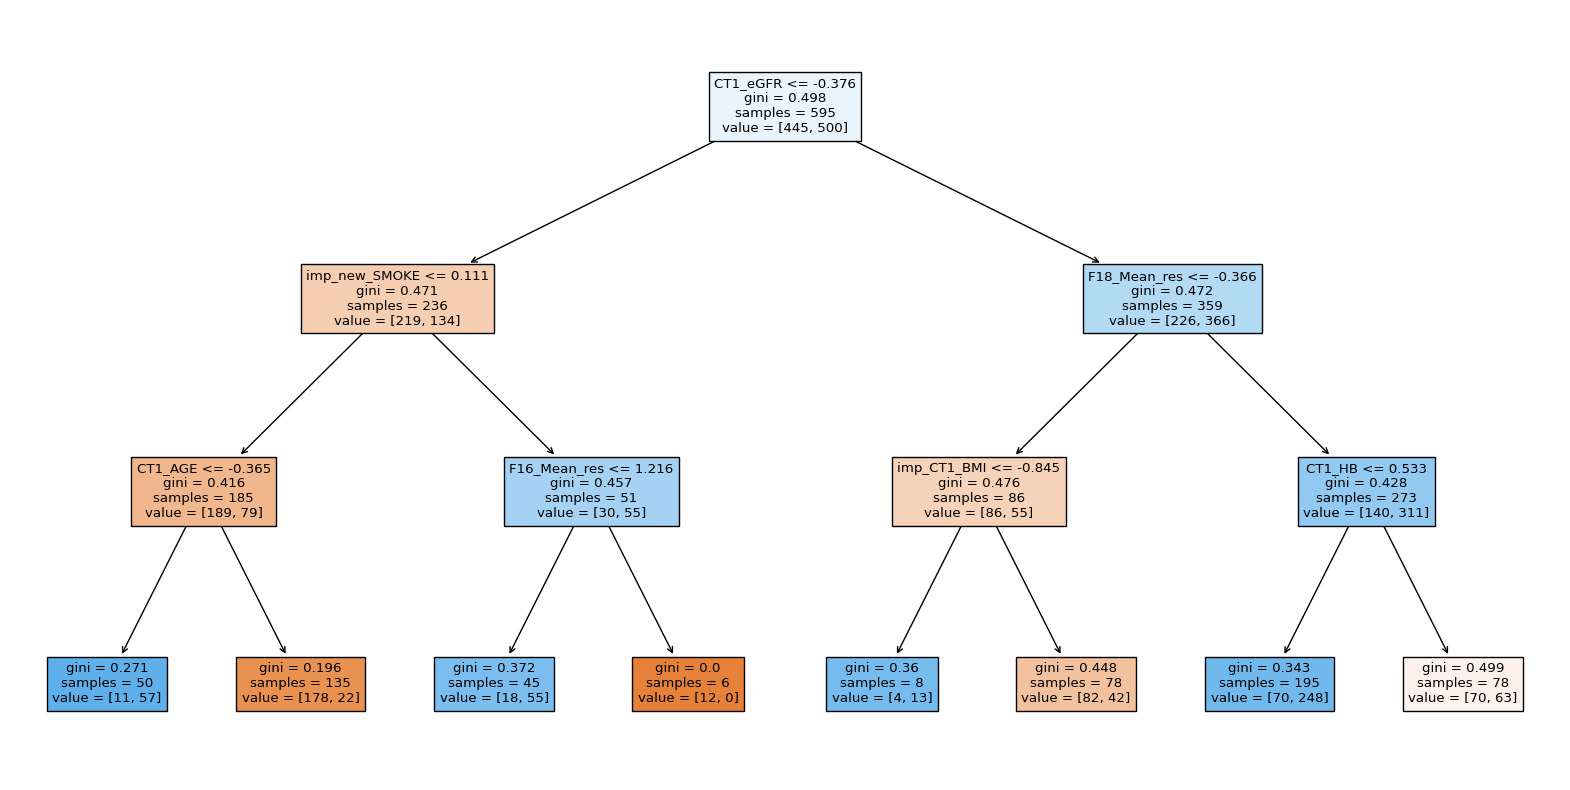

In [19]:
""" Visualization for tree-based model """

from sklearn.tree import plot_tree

# # GBC
# my_models = models[0][1]
# plt.figure(figsize=(20, 10))
# plot_tree(my_models.estimators_[0][0], feature_names=tight3_foodsum.columns, filled=True)
# plt.show()

# RF
my_models = models[0][1]
plt.figure(figsize=(20, 10))
plot_tree(my_models.estimators_[0], feature_names=tight3_foodsum.columns, filled=True)
plt.show()

In [7]:
""" Apply shap value for all fold & SAVE"""

# seed = 59

# for seed in [42, 59, 63, 79, 101]:
for seed in [42]:
    # 저장 경로 설정
    dataset_name = "basic_foodadjmean_under"
    shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    # datas['undersampling'] = undersampling(tight3_foodsum.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]
    
    # wei_train_scaler = StandardScaler()
    # X_train = wei_train_scaler.fit_transform(X_train)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    models = [
        # ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),     # 50분 소요
        # ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        # ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        # ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("XGBoost", xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed))
        ("GNB", GaussianNB(var_smoothing=1e-7)),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7       # 17분 소요
    ]

    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        for name, model in models:
            print(f"Training {name} model on fold {fold_num}...")
            model.fit(X_fold_train, y_fold_train)
            print(f"Model fitted!!")
    
    for name, model in models:
        # SHAP Explainer 설정
        if name in ["RandomForest", "GradientBoosting", "XGBoost"]:
            explainer = shap.TreeExplainer(model)
        elif name in ["SVC", "GNB"]:
            explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))  # 샘플링하여 속도 향상
        elif name == "LogisticRegression":
            explainer = shap.LinearExplainer(model, X_train)
        
        start = time.time()
        if name in ["SVC", "GNB"]:
            shap_values = explainer.shap_values(X_train, silent=True)
        else:
            shap_values = explainer.shap_values(X_train)
        end = time.time()
        print(f"{name} model :: running time for shap value calculation : {end - start}")
        
        
        save_path_model = os.path.join(shap_fig_dir, f"{model.__class__.__name__}")
        os.makedirs(save_path_model, exist_ok=True)
        save_path = os.path.join(save_path_model, f"summary_plot, model_{model.__class__.__name__}, all_fold.png")
        
        plt.figure()
        if name in ["SVC", "RandomForest", "GNB"]:
            shap.summary_plot(shap_values[1], X_train, feature_names=X_train.columns.tolist(), show=False)
        else:
            shap.summary_plot(shap_values, X_train[0], feature_names=X_train.columns.tolist(), show=False)
        plt.title(f"Summary plot for all samples of {model.__class__.__name__}")
        plt.savefig(save_path)
        plt.close()
        print("Fig saved!!!")
        ## Shap value save
        save_path_shap = os.path.join(save_path_model, "shap_values_all_fold.pk")
        
        with open(save_path_shap, 'wb') as f:
            pickle.dump(shap_values, f)
        print(f"All SHAP values saved to {save_path_shap}.")
        
        save_path_model_weights = os.path.join(save_path_model, f"{model.__class__.__name__}_weights.joblib")
        dump(model, save_path_model_weights)
        print(f"Model weight is saved!!")

Training GNB model on fold 1...
Model fitted!!
Training GNB model on fold 2...
Model fitted!!
Training GNB model on fold 3...
Model fitted!!
Training GNB model on fold 4...
Model fitted!!
Training GNB model on fold 5...
Model fitted!!
Training GNB model on fold 6...
Model fitted!!
Training GNB model on fold 7...
Model fitted!!
Training GNB model on fold 8...
Model fitted!!
Training GNB model on fold 9...
Model fitted!!
Training GNB model on fold 10...
Model fitted!!


KeyboardInterrupt: 

In [38]:
shap_values

array([[ 0.04612631, -0.4146524 , -2.40216669, ...,  0.02808628,
        -0.01580836, -0.01373783],
       [-0.05870621, -0.02420758, -1.0007197 , ..., -0.14567993,
        -0.04186875, -0.01778132],
       [-0.05870621, -0.57083032, -2.73130907, ...,  0.02427901,
        -0.03091879, -0.02095652],
       ...,
       [ 0.04612631,  0.60050413,  3.00973259, ...,  0.05007573,
        -0.01365472, -0.01364774],
       [-0.05870621,  0.52241516,  0.33376955, ...,  0.03423049,
        -0.03397621, -0.01740822],
       [-0.05870621,  0.67859309, -0.74890587, ..., -0.04920442,
        -0.02956087, -0.01499346]])

In [39]:
explainer.expected_value

-0.7163293163152933

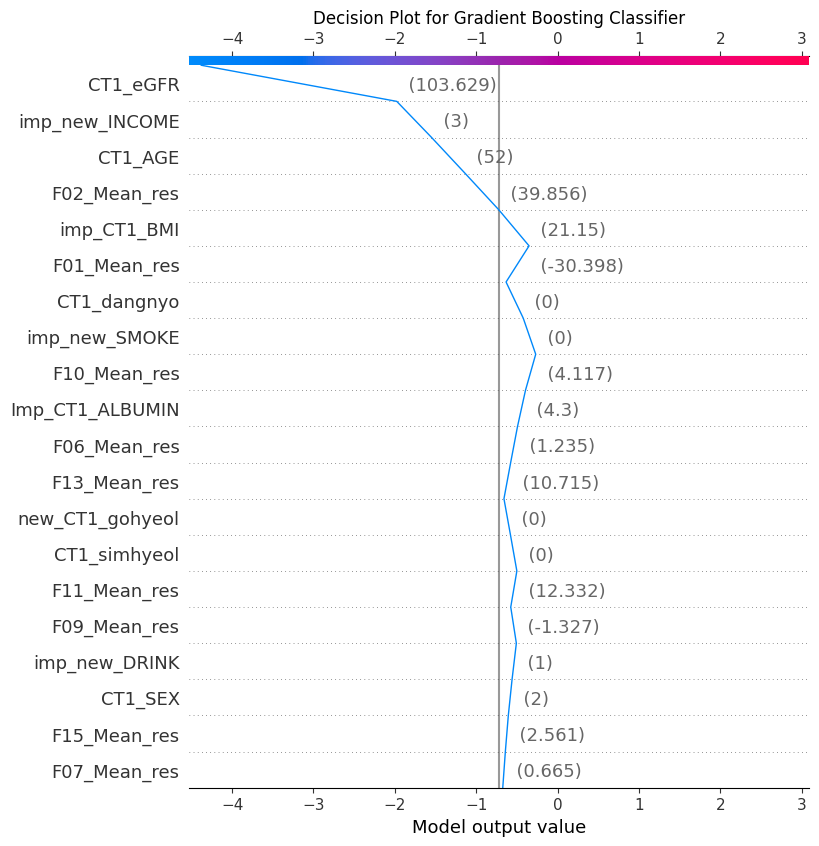

In [40]:
sample_index=0
shap.decision_plot(
    explainer.expected_value,
    shap_values[sample_index],
    X_train.values[sample_index],
    feature_names=X_train.columns.tolist(),
    title="Decision Plot for Gradient Boosting Classifier"
)

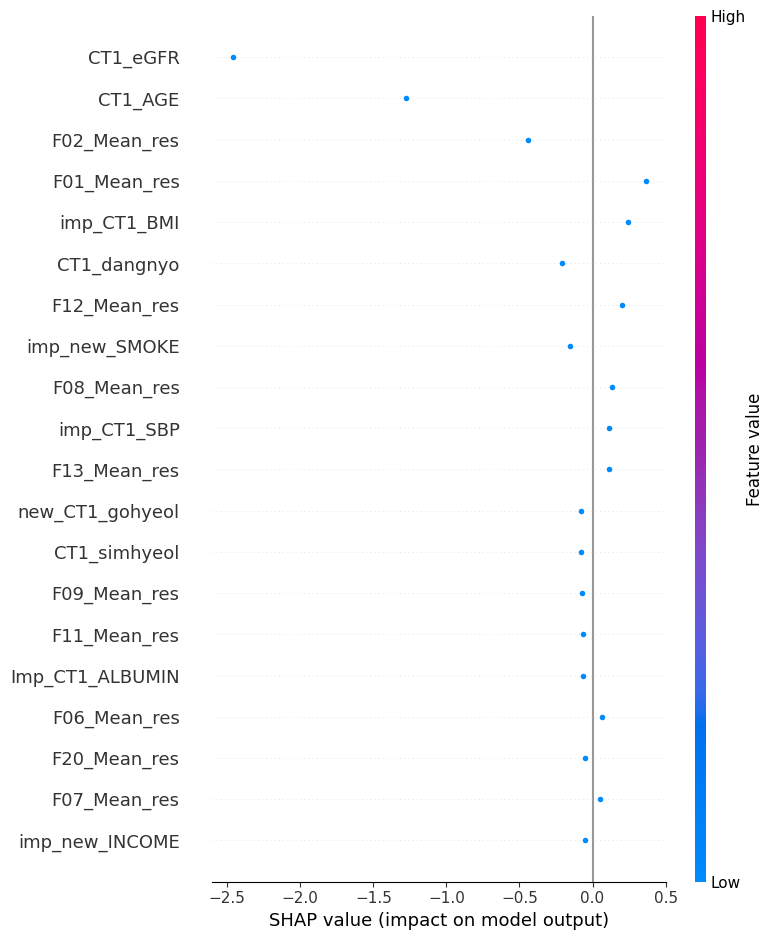

In [42]:
sample_index = 43
# summary plot을 하나씩 
shap.summary_plot(
    shap_values[sample_index:sample_index+1],
    X_train[sample_index:sample_index+1],
    feature_names=X_train.columns.tolist(),
    # plot_type='bar'
    )

##### Other visualization

In [ ]:
# """ Check feature importances """

# # X_train, X_test, y_train, y_test = train_test_split(datas['undersampling'][0], datas['undersampling'][1], test_size=0.1, random_state=42)
# X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]

# # Tree-based 모델 훈련
# models = (RandomForestClassifier(random_state=42),
#           GradientBoostingClassifier(random_state=42, max_depth=3, learning_rate=0.01),
#           xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False))

# for rf in models:
#     rf.fit(X_train, y_train)

#     # 특성 중요도 계산
#     importances = rf.feature_importances_
#     indices = np.argsort(importances)[::-1]

#     # 특성 중요도 시각화
#     plt.figure(figsize=(10, 6))
#     plt.title(f"Feature importances by {rf.__class__.__name__}")
#     plt.bar(range(X_train.shape[1]), importances[indices], align="center")
#     plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
#     plt.show()

#### Only Basic from adjmean

##### Only Basic from adjmean CV

In [20]:
""" Only Basic dataset """

results_all_seed = {}

n_split = 10
for seed in [42, 59, 63, 79, 101]:    
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(tight3_foodsum_basic, seed=seed)
    datas['oversampling'] = oversampling(tight3_foodsum_basic, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_basic['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_basic.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
    results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        # X_test, y_test = datas['test']
        X_train, y_train = datas[data]
        
        wei_train_scaler = StandardScaler()
        X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        scoring = {
        'recall': 'recall_macro',      # recall for each class, then averaged
        'precision': 'precision_macro',# precision for each class, then averaged
        'accuracy': 'accuracy',        # accuracy
        'auc': make_scorer(roc_auc_score, multi_class='ovr')  # AUC 계산 (이진 분류시)
        }
        
        models = (
            # SVC(kernel='linear', random_state=seed, probability=True),
            RandomForestClassifier(random_state=seed, max_depth=3),
            # LogisticRegression(max_iter=1000, random_state=seed),
            # GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
            # GaussianNB(var_smoothing=1e-7),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7
            # xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)
        )
        
        for i, model in enumerate(models):
            model_name = model.__class__.__name__  # 모델 이름 저장
            print("=" * 30)
            print(f"Cross Validation for {model} in fold {n_split}, with seed {seed}")
            # Stratified K-Fold 교차 검증 (K=5)
            skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
            results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)

            # 결과 출력
            print("각 폴드의 Recall:", results['test_recall'])
            print("각 폴드의 Precision:", results['test_precision'])
            print("각 폴드의 Accuracy:", results['test_accuracy'])
            print("각 폴드의 AUC:", results['test_auc'])

            # 결과 저장
            if model_name not in results_all_seed[seed]:
                results_all_seed[seed][model_name] = {
                    'recall': [], 
                    'precision': [], 
                    'accuracy': [], 
                    'auc': [],
                    'recall_std': [], 
                    'precision_std': [], 
                    'accuracy_std': [], 
                    'auc_std': []
                }
            results_all_seed[seed][model_name]['recall'].append(np.mean(results['test_recall']))
            results_all_seed[seed][model_name]['precision'].append(np.mean(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy'].append(np.mean(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc'].append(np.mean(results['test_auc']))
            results_all_seed[seed][model_name]['recall_std'].append(np.std(results['test_recall']))
            results_all_seed[seed][model_name]['precision_std'].append(np.std(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy_std'].append(np.std(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc_std'].append(np.std(results['test_auc']))
            
            
            # 평균값 계산
            print("평균 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.mean(results['test_recall']), 4)}, {round(np.mean(results['test_precision']),4)}, {round(np.mean(results['test_accuracy']), 4)}, {round(np.mean(results['test_auc']), 4)}")
            print("표준편차 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.std(results['test_recall']), 4)}, {round(np.std(results['test_precision']),4)}, {round(np.std(results['test_accuracy']), 4)}, {round(np.std(results['test_auc']), 4)}")
            print()
            
print_cv_results_ML(results_all_seed)

For undersampling dataset!!!
undersampling dataset loaded and scaled
X_train :: (1050, 15), y_train :: (1050,)
Cross Validation for RandomForestClassifier(max_depth=3, random_state=42) in fold 5, with seed 42
각 폴드의 Recall: [0.86190476 0.81428571 0.84285714 0.9        0.82857143]
각 폴드의 Precision: [0.86272727 0.81454248 0.84288824 0.90090909 0.82904896]
각 폴드의 Accuracy: [0.86190476 0.81428571 0.84285714 0.9        0.82857143]
각 폴드의 AUC: [0.86190476 0.81428571 0.84285714 0.9        0.82857143]
평균 Recall, Precision, Accuracy, AUC:
0.8495, 0.85, 0.8495, 0.8495
표준편차 Recall, Precision, Accuracy, AUC:
0.0298, 0.03, 0.0298, 0.0298

For undersampling dataset!!!
undersampling dataset loaded and scaled
X_train :: (1050, 15), y_train :: (1050,)
Cross Validation for RandomForestClassifier(max_depth=3, random_state=59) in fold 5, with seed 59
각 폴드의 Recall: [0.82380952 0.81428571 0.86190476 0.8        0.88095238]
각 폴드의 Precision: [0.8252551  0.81454248 0.86220044 0.80010888 0.88181818]
각 폴드의 Accuracy: 

In [19]:
""" Apply shap value for each fold & SAVE"""

# seed = 59

for seed in [42, 59, 63, 79, 101]:
# for seed in [42]:
    # 저장 경로 설정
    dataset_name = "basic_only_under_fromadjmean"
    shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    # datas['undersampling'] = undersampling(tight3_foodsum_basic.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum_basic, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum_basic, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_basic['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_basic.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]


    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    models = [
        # ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),
        # ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        # ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        # ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("XGBoost", xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)),
        ("GNB", GaussianNB(var_smoothing=1e-7)),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7
    ]
    
    # models = (
    #         # SVC(kernel='linear', random_state=seed, probability=True),
    #         # RandomForestClassifier(random_state=seed, max_depth=3),
    #         # LogisticRegression(max_iter=1000, random_state=seed),
    #         # GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
    #         GaussianNB(var_smoothing=1e-7),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7
    #         # xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)
    #     )

    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        for name, model in models:
            print(f"Training {name} model on fold {fold_num}...")
            model.fit(X_fold_train, y_fold_train)
            print(f"Model fitted!!")
        
        preds = model.predict(X_fold_test)
        model_probabilities = model.predict_proba(X_fold_test)[:, 1]
        get_results(y_fold_test, np.array(preds), model_probabilities)
        

Training GNB model on fold 1...
Model fitted!!
[[44  9]
 [10 42]]
Recall 	 Precision 	 Acc 	 AUC
0.8077 0.8235 0.819 0.8886
Training GNB model on fold 2...
Model fitted!!
[[44  9]
 [ 4 48]]
Recall 	 Precision 	 Acc 	 AUC
0.9231 0.8421 0.8762 0.918
Training GNB model on fold 3...
Model fitted!!
[[42 11]
 [ 7 45]]
Recall 	 Precision 	 Acc 	 AUC
0.8654 0.8036 0.8286 0.9115
Training GNB model on fold 4...
Model fitted!!
[[45  8]
 [14 38]]
Recall 	 Precision 	 Acc 	 AUC
0.7308 0.8261 0.7905 0.8661
Training GNB model on fold 5...
Model fitted!!
[[41 12]
 [ 7 45]]
Recall 	 Precision 	 Acc 	 AUC
0.8654 0.7895 0.819 0.8683
Training GNB model on fold 6...
Model fitted!!
[[42 10]
 [ 8 45]]
Recall 	 Precision 	 Acc 	 AUC
0.8491 0.8182 0.8286 0.8835
Training GNB model on fold 7...
Model fitted!!
[[46  6]
 [ 6 47]]
Recall 	 Precision 	 Acc 	 AUC
0.8868 0.8868 0.8857 0.9191
Training GNB model on fold 8...
Model fitted!!
[[44  8]
 [ 8 45]]
Recall 	 Precision 	 Acc 	 AUC
0.8491 0.8491 0.8476 0.9205
Tra

In [27]:
""" Basic Only (Basic) , OR value & 95% CI 계산하기"""

seed_results = {}

for seed in [42, 59, 63, 79, 101]:
    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    datas['undersampling'] = undersampling(tight3_foodsum_basic, seed=seed)
    datas['oversampling'] = oversampling(tight3_foodsum_basic, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_basic['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_basic.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]
    
    # wei_train_scaler = StandardScaler()
    # X_train = wei_train_scaler.fit_transform(X_train)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    
    # 각 fold마다 conf DataFrame을 저장할 리스트 초기화
    fold_confs = []
    print(f"Seed : {seed}!!!")
    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # print(f"Training model on fold {fold_num}...")
        model = sm.Logit(y_fold_train, X_fold_train)
        result = model.fit(disp=0)  # disp=0으로 출력 억제
       
        # OR 및 신뢰 구간 계산
        odds_ratios = np.exp(result.params)
        conf = result.conf_int()
        conf['OR'] = odds_ratios
        conf['p-value'] = result.pvalues
        conf.columns = ['2.5%', '97.5%', 'OR', 'p-value']
        conf['95% CI'] = conf['97.5%'] - conf['2.5%']
        
        
        # 각 fold의 결과를 리스트에 저장
        fold_confs.append(conf[['OR', '2.5%', '97.5%', '95% CI', 'p-value']])

    
    # 각 fold 결과를 평균 내서 seed별 OR 값과 신뢰 구간 계산
    mean_conf = pd.concat(fold_confs).groupby(level=0).mean()
    mean_conf = mean_conf.reindex(X_train.columns)
    seed_results[seed] = mean_conf

# 최종 결과를 하나의 DataFrame으로 변환
all_seeds_df = pd.concat(seed_results, names=['Seed', 'Feature']).reset_index()
# print("\nFinal OR and 95% CI by seed:\n", all_seeds_df)

# 모든 seed에 대한 평균 계산
mean_across_seeds = all_seeds_df.groupby('Feature')[['OR', '2.5%', '97.5%', '95% CI', 'p-value']].mean()
mean_across_seeds = mean_across_seeds.reindex(X_train.columns)
# print("\nMean OR and 95% CI across all seeds:\n", mean_across_seeds)
mean_across_seeds.to_excel("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs/10fold_5seed_ORvalues_averaged_basiconly.xlsx")

Seed : 42!!!
Seed : 59!!!
Seed : 63!!!
Seed : 79!!!
Seed : 101!!!


In [28]:
mean_across_seeds

,OR,2.5%,97.5%,95% CI,p-value
CT1_SEX,1.112709,-0.466553,0.654097,1.120650,5.788920e-01
CT1_AGE,1.079056,0.050818,0.101316,0.050498,4.698018e-08
CT1_eGFR,0.896597,-0.126480,-0.091856,0.034624,4.413114e-33
imp_CT1_SBP,1.022151,0.007405,0.036362,0.028957,4.137318e-02
imp_CT1_BMI,1.115508,0.042734,0.175200,0.132466,7.222167e-03
CT1_HB,0.955898,-0.216672,0.124056,0.340728,5.961028e-01
Imp_CT1_ALBUMIN,0.971289,-0.666629,0.547492,1.214121,5.290811e-01
CT1_TCHL,0.998370,-0.006997,0.003731,0.010727,5.831245e-01
imp_new_EDU,1.048047,-0.221452,0.309859,0.531311,6.200273e-01
imp_new_INCOME,0.788427,-0.553644,0.070742,0.624386,1.808516e-01


##### Only basic shap value visualization

In [14]:
""" Apply shap value for each fold & SAVE"""

# seed = 59

for seed in [42, 59, 63, 79, 101]:
# for seed in [42]:
    # 저장 경로 설정
    dataset_name = "basic_only_under_fromadjmean"
    shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    # datas['undersampling'] = undersampling(tight3_foodsum_basic.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum_basic, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum_basic, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_basic['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_basic.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]


    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    shap_values_all_models = {"SVC" : [],
                            "RandomForest" : [],
                            "LogisticRegression" : [],
                            "GradientBoosting" : [],
                            "XGBoost" : [],
                            }

    models = [
        ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),
        ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("XGBoost", xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed))
    ]

    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        for name, model in models:
            print(f"Training {name} model on fold {fold_num}...")
            model.fit(X_fold_train, y_fold_train)
            print(f"Model fitted!!")
            
            # SHAP Explainer 설정
            if name in ["RandomForest", "GradientBoosting", "XGBoost"]:
                explainer = shap.TreeExplainer(model)
            elif name == "SVC":
                explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_fold_train, 100))  # 샘플링하여 속도 향상
            elif name == "LogisticRegression":
                explainer = shap.LinearExplainer(model, X_fold_train)
            
            # SHAP 값 계산
            if name =="SVC":
                shap_values = explainer.shap_values(X_fold_test, silent=True)
            else:
                shap_values = explainer.shap_values(X_fold_test)
            shap_values_all_models[name].append(shap_values)
            
            # Summary plot 그리기 및 저장
            plt.figure()
            print(f"Plotting and saving SHAP Summary for {name} on fold {fold_num}...")

            save_path_model = os.path.join(shap_fig_dir, f"{model.__class__.__name__}")
            os.makedirs(save_path_model, exist_ok=True)
            save_path = os.path.join(save_path_model, f"summary_plot, model_{model.__class__.__name__}, fold_{fold_num}.png")

            # Summary plot 저장
            if name in ["SVC", "RandomForest"]:
                shap.summary_plot(shap_values[1], X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            else:
                shap.summary_plot(shap_values, X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            plt.title(f"Summary plot for {fold_num} fold of {model.__class__.__name__}")
            plt.savefig(save_path)
            plt.close()

    # 모든 fold가 끝난 후 shap_values_all_models 저장
    shap_values_save_path = os.path.join(shap_fig_dir, "shap_values_all_models.pk")

    # pickle을 사용하여 shap_values_all_models 저장
    with open(shap_values_save_path, 'wb') as f:
        pickle.dump(shap_values_all_models, f)

    print(f"All SHAP values saved to {shap_values_save_path}.")

Training SVC model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for SVC on fold 1...
Training RandomForest model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for RandomForest on fold 1...
Training LogisticRegression model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for LogisticRegression on fold 1...
Training GradientBoosting model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for GradientBoosting on fold 1...
Training SVC model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for SVC on fold 2...
Training RandomForest model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for RandomForest on fold 2...
Training LogisticRegression model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for LogisticRegression on fold 2...
Training GradientBoosting model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for GradientBoosting on fold 2...
Training SVC model on fold 3...
Model fitted

In [7]:
tight3_foodsum_basic.columns

Index(['RID', 'CT1_SEX', 'CT1_AGE', 'CT1_eGFR', 'imp_CT1_SBP', 'imp_CT1_BMI',
       'CT1_HB', 'Imp_CT1_ALBUMIN', 'CT1_TCHL', 'imp_new_EDU',
       'imp_new_INCOME', 'imp_new_DRINK', 'imp_new_SMOKE', 'new_CT1_gohyeol',
       'CT1_dangnyo', 'CT1_simhyeol', 'onset_tight'],
      dtype='object')

In [8]:
""" Apply shap value for all fold & SAVE"""

# seed = 59

for seed in [42, 59, 63, 79, 101]:
# for seed in [42]:
    # 저장 경로 설정
    dataset_name = "basic_only_under_fromadjmean"
    shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    datas['undersampling'] = undersampling(tight3_foodsum_basic, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum_basic, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_basic['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_basic.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]
    
    # wei_train_scaler = StandardScaler()
    # X_train = wei_train_scaler.fit_transform(X_train)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    models = [
        # ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),
        ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("XGBoost", xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed))
        # ("GNB", GaussianNB(var_smoothing=1e-7)),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7       # 17분 소요
    ]

    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        for name, model in models:
            print(f"Training {name} model on fold {fold_num}...")
            model.fit(X_fold_train, y_fold_train)
            print(f"Model fitted!!")
    
    for name, model in models:
        # SHAP Explainer 설정
        if name in ["RandomForest", "GradientBoosting", "XGBoost"]:
            explainer = shap.TreeExplainer(model)
        elif name in ["GradientBoosting", "XGBoost"]:
            explainer = shap.TreeExplainer(model, X_train)
        elif name in ["SVC", "GNB"]:
            explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))  # 샘플링하여 속도 향상
        elif name == "LogisticRegression":
            explainer = shap.LinearExplainer(model, X_train)
        
        start = time.time()
        if name in ["SVC", "GNB"]:
            shap_values = explainer.shap_values(X_train, silent=True)
        else:
            shap_values = explainer.shap_values(X_train)
        end = time.time()
        print(f"{name} model :: running time for shap value calculation : {end - start}")
        
        save_path_model = os.path.join(shap_fig_dir, f"{model.__class__.__name__}")
        os.makedirs(save_path_model, exist_ok=True)
        save_path = os.path.join(save_path_model, f"summary_plot, model_{model.__class__.__name__}, all_fold.png")
        
        plt.figure()
        if name in ["SVC", "RandomForest", "GNB"]:
            shap.summary_plot(shap_values[1], X_train, feature_names=X_train.columns.tolist(), show=False)
        else:
            shap.summary_plot(shap_values, X_train, feature_names=X_train.columns.tolist(), show=False)
        plt.title(f"Summary plot for all samples of {model.__class__.__name__}")
        plt.savefig(save_path)
        plt.close()
        
        ## Shap value save
        save_path_shap = os.path.join(save_path_model, "shap_values_all_fold.pk")
        
        with open(save_path_shap, 'wb') as f:
            pickle.dump(shap_values, f)
        print(f"All SHAP values saved to {save_path_shap}.")
        
        save_path_model_weights = os.path.join(save_path_model, f"{model.__class__.__name__}_weights.joblib")
        dump(model, save_path_model_weights)
        print(f"Model weight is saved!!")

Training RandomForest model on fold 1...
Model fitted!!
Training LogisticRegression model on fold 1...
Model fitted!!
Training GradientBoosting model on fold 1...
Model fitted!!
Training RandomForest model on fold 2...
Model fitted!!
Training LogisticRegression model on fold 2...
Model fitted!!
Training GradientBoosting model on fold 2...
Model fitted!!
Training RandomForest model on fold 3...
Model fitted!!
Training LogisticRegression model on fold 3...
Model fitted!!
Training GradientBoosting model on fold 3...
Model fitted!!
Training RandomForest model on fold 4...
Model fitted!!
Training LogisticRegression model on fold 4...
Model fitted!!
Training GradientBoosting model on fold 4...
Model fitted!!
Training RandomForest model on fold 5...
Model fitted!!
Training LogisticRegression model on fold 5...
Model fitted!!
Training GradientBoosting model on fold 5...
Model fitted!!
Training RandomForest model on fold 6...
Model fitted!!
Training LogisticRegression model on fold 6...
Model f

##### Other visualization

In [ ]:
# # X_train, X_test, y_train, y_test = train_test_split(datas['undersampling'][0], datas['undersampling'][1], test_size=0.1, random_state=42)
# X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]

# # Tree-based 모델 훈련
# models = (RandomForestClassifier(random_state=42),
#           GradientBoostingClassifier(random_state=42, max_depth=3, learning_rate=0.01),
#           xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False))

# for rf in models:
#     rf.fit(X_train, y_train)

#     # 특성 중요도 계산
#     importances = rf.feature_importances_
#     indices = np.argsort(importances)[::-1]

#     # 특성 중요도 시각화
#     plt.figure(figsize=(10, 6))
#     plt.title(f"Feature importances by {rf.__class__.__name__}")
#     plt.bar(range(X_train.shape[1]), importances[indices], align="center")
#     plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
#     plt.show()

#### Only Food adjmean

##### Only food adjmean CV

In [21]:
""" Only Food dataset """

results_all_seed = {}

n_split = 10
for seed in [42, 59, 63, 79, 101]:    
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(tight3_foodsum_food, seed=seed)
    datas['oversampling'] = oversampling(tight3_foodsum_food, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_food['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_food.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
    results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        # X_test, y_test = datas['test']
        X_train, y_train = datas[data]
        
        wei_train_scaler = StandardScaler()
        X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        scoring = {
        'recall': 'recall_macro',      # recall for each class, then averaged
        'precision': 'precision_macro',# precision for each class, then averaged
        'accuracy': 'accuracy',        # accuracy
        'auc': make_scorer(roc_auc_score, multi_class='ovr')  # AUC 계산 (이진 분류시)
        }
        
        models = (
            # SVC(kernel='linear', random_state=seed, probability=True),
            RandomForestClassifier(random_state=seed, max_depth=3),
            # LogisticRegression(max_iter=1000, random_state=seed),
            # GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
            # GaussianNB(var_smoothing=1e-7),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7
            # xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)
        )
        
        for i, model in enumerate(models):
            model_name = model.__class__.__name__  # 모델 이름 저장
            print("=" * 30)
            print(f"Cross Validation for {model} in fold {n_split}, with seed {seed}")
            # Stratified K-Fold 교차 검증 (K=5)
            skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
            results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)

            # 결과 출력
            print("각 폴드의 Recall:", results['test_recall'])
            print("각 폴드의 Precision:", results['test_precision'])
            print("각 폴드의 Accuracy:", results['test_accuracy'])
            print("각 폴드의 AUC:", results['test_auc'])

            # 결과 저장
            if model_name not in results_all_seed[seed]:
                results_all_seed[seed][model_name] = {
                    'recall': [], 
                    'precision': [], 
                    'accuracy': [], 
                    'auc': [],
                    'recall_std': [], 
                    'precision_std': [], 
                    'accuracy_std': [], 
                    'auc_std': []
                }
            results_all_seed[seed][model_name]['recall'].append(np.mean(results['test_recall']))
            results_all_seed[seed][model_name]['precision'].append(np.mean(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy'].append(np.mean(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc'].append(np.mean(results['test_auc']))
            results_all_seed[seed][model_name]['recall_std'].append(np.std(results['test_recall']))
            results_all_seed[seed][model_name]['precision_std'].append(np.std(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy_std'].append(np.std(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc_std'].append(np.std(results['test_auc']))
            
            
            # 평균값 계산
            print("평균 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.mean(results['test_recall']), 4)}, {round(np.mean(results['test_precision']),4)}, {round(np.mean(results['test_accuracy']), 4)}, {round(np.mean(results['test_auc']), 4)}")
            print("표준편차 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.std(results['test_recall']), 4)}, {round(np.std(results['test_precision']),4)}, {round(np.std(results['test_accuracy']), 4)}, {round(np.std(results['test_auc']), 4)}")
            print()
            
print_cv_results_ML(results_all_seed)

For undersampling dataset!!!
undersampling dataset loaded and scaled
X_train :: (1050, 21), y_train :: (1050,)
Cross Validation for RandomForestClassifier(max_depth=3, random_state=42) in fold 5, with seed 42
각 폴드의 Recall: [0.68095238 0.62380952 0.66666667 0.66190476 0.67619048]
각 폴드의 Precision: [0.68376934 0.62472588 0.68148148 0.6733683  0.67676768]
각 폴드의 Accuracy: [0.68095238 0.62380952 0.66666667 0.66190476 0.67619048]
각 폴드의 AUC: [0.68095238 0.62380952 0.66666667 0.66190476 0.67619048]
평균 Recall, Precision, Accuracy, AUC:
0.6619, 0.668, 0.6619, 0.6619
표준편차 Recall, Precision, Accuracy, AUC:
0.0202, 0.0219, 0.0202, 0.0202

For undersampling dataset!!!
undersampling dataset loaded and scaled
X_train :: (1050, 21), y_train :: (1050,)
Cross Validation for RandomForestClassifier(max_depth=3, random_state=59) in fold 5, with seed 59
각 폴드의 Recall: [0.64761905 0.66666667 0.7047619  0.64761905 0.71904762]
각 폴드의 Precision: [0.65317647 0.66887235 0.72043746 0.64810265 0.72002551]
각 폴드의 Accurac

In [29]:
""" Adjmean Only (Food) , OR value & 95% CI 계산하기"""

seed_results = {}

for seed in [42, 59, 63, 79, 101]:
    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    datas['undersampling'] = undersampling(tight3_foodsum_food, seed=seed)
    datas['oversampling'] = oversampling(tight3_foodsum_food, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_food['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_food.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]
    
    # wei_train_scaler = StandardScaler()
    # X_train = wei_train_scaler.fit_transform(X_train)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    
    # 각 fold마다 conf DataFrame을 저장할 리스트 초기화
    fold_confs = []
    print(f"Seed : {seed}!!!")
    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # print(f"Training model on fold {fold_num}...")
        model = sm.Logit(y_fold_train, X_fold_train)
        result = model.fit(disp=0)  # disp=0으로 출력 억제
       
        # OR 및 신뢰 구간 계산
        odds_ratios = np.exp(result.params)
        conf = result.conf_int()
        conf['OR'] = odds_ratios
        conf['p-value'] = result.pvalues
        conf.columns = ['2.5%', '97.5%', 'OR', 'p-value']
        conf['95% CI'] = conf['97.5%'] - conf['2.5%']
        
        
        # 각 fold의 결과를 리스트에 저장
        fold_confs.append(conf[['OR', '2.5%', '97.5%', '95% CI', 'p-value']])

    
    # 각 fold 결과를 평균 내서 seed별 OR 값과 신뢰 구간 계산
    mean_conf = pd.concat(fold_confs).groupby(level=0).mean()
    mean_conf = mean_conf.reindex(X_train.columns)
    seed_results[seed] = mean_conf

# 최종 결과를 하나의 DataFrame으로 변환
all_seeds_df = pd.concat(seed_results, names=['Seed', 'Feature']).reset_index()
# print("\nFinal OR and 95% CI by seed:\n", all_seeds_df)

# 모든 seed에 대한 평균 계산
mean_across_seeds = all_seeds_df.groupby('Feature')[['OR', '2.5%', '97.5%', '95% CI', 'p-value']].mean()
mean_across_seeds = mean_across_seeds.reindex(X_train.columns)
# print("\nMean OR and 95% CI across all seeds:\n", mean_across_seeds)
mean_across_seeds.to_excel("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs/10fold_5seed_ORvalues_averaged_adjmeanonly.xlsx")

Seed : 42!!!
Seed : 59!!!
Seed : 63!!!
Seed : 79!!!
Seed : 101!!!


In [30]:
mean_across_seeds

,OR,2.5%,97.5%,95% CI,p-value
F01_Mean_res,0.997790,-0.004870,0.000444,0.005313,0.224499
F02_Mean_res,0.995583,-0.008343,-0.000513,0.007830,0.058241
F03_Mean_res,0.999475,-0.011523,0.010462,0.021985,0.693753
F04_Mean_res,1.023624,-0.010321,0.056702,0.067024,0.316935
F05_Mean_res,0.990880,-0.033216,0.014829,0.048045,0.496186
F06_Mean_res,1.023263,-0.051472,0.097074,0.148546,0.535998
F07_Mean_res,1.002777,-0.032017,0.037313,0.069330,0.494983
F08_Mean_res,0.999920,-0.009175,0.009010,0.018185,0.697045
F09_Mean_res,1.002054,-0.034545,0.038550,0.073094,0.705501
F10_Mean_res,0.986643,-0.050298,0.023324,0.073622,0.505721


##### Only food adjmean shap value visualization

In [15]:
""" Apply shap value for each fold & SAVE"""

# seed = 59

for seed in [42, 59, 63, 79, 101]:
# for seed in [42]:
    # 저장 경로 설정
    dataset_name = "foodadjmean_only_under"
    shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}
    # datas['undersampling'] = undersampling(tight3_foodsum_food.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum_food, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum_food, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_food['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_food.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]


    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    shap_values_all_models = {"SVC" : [],
                            "RandomForest" : [],
                            "LogisticRegression" : [],
                            "GradientBoosting" : [],
                            "XGBoost" : [],
                            }

    models = [
        ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),
        ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("XGBoost", xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed))
    ]

    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        for name, model in models:
            print(f"Training {name} model on fold {fold_num}...")
            model.fit(X_fold_train, y_fold_train)
            print(f"Model fitted!!")
            
            # SHAP Explainer 설정
            if name in ["RandomForest", "GradientBoosting", "XGBoost"]:
                explainer = shap.TreeExplainer(model)
            elif name == "SVC":
                explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_fold_train, 100))  # 샘플링하여 속도 향상
            elif name == "LogisticRegression":
                explainer = shap.LinearExplainer(model, X_fold_train)
            
            # SHAP 값 계산
            if name =="SVC":
                shap_values = explainer.shap_values(X_fold_test, silent=True)
            else:
                shap_values = explainer.shap_values(X_fold_test)
            shap_values_all_models[name].append(shap_values)
            
            # Summary plot 그리기 및 저장
            plt.figure()
            print(f"Plotting and saving SHAP Summary for {name} on fold {fold_num}...")

            save_path_model = os.path.join(shap_fig_dir, f"{model.__class__.__name__}")
            os.makedirs(save_path_model, exist_ok=True)
            save_path = os.path.join(save_path_model, f"summary_plot, model_{model.__class__.__name__}, fold_{fold_num}.png")

            # Summary plot 저장
            if name in ["SVC", "RandomForest"]:
                shap.summary_plot(shap_values[1], X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            else:
                shap.summary_plot(shap_values, X_fold_test, feature_names=X_train.columns.tolist(), show=False)
            plt.title(f"Summary plot for {fold_num} fold of {model.__class__.__name__}")
            plt.savefig(save_path)
            plt.close()

    # 모든 fold가 끝난 후 shap_values_all_models 저장
    shap_values_save_path = os.path.join(shap_fig_dir, "shap_values_all_models.pk")

    # pickle을 사용하여 shap_values_all_models 저장
    with open(shap_values_save_path, 'wb') as f:
        pickle.dump(shap_values_all_models, f)

    print(f"All SHAP values saved to {shap_values_save_path}.")

Training SVC model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for SVC on fold 1...
Training RandomForest model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for RandomForest on fold 1...
Training LogisticRegression model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for LogisticRegression on fold 1...
Training GradientBoosting model on fold 1...
Model fitted!!
Plotting and saving SHAP Summary for GradientBoosting on fold 1...
Training SVC model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for SVC on fold 2...
Training RandomForest model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for RandomForest on fold 2...
Training LogisticRegression model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for LogisticRegression on fold 2...
Training GradientBoosting model on fold 2...
Model fitted!!
Plotting and saving SHAP Summary for GradientBoosting on fold 2...
Training SVC model on fold 3...
Model fitted

In [9]:
""" Apply shap value for all fold & SAVE"""

# seed = 59

for seed in [42, 59, 63, 79, 101]:
# for seed in [42]:
    # 저장 경로 설정
    dataset_name = "foodadjmean_only_under"
    shap_fig_dir = f"shap_figs/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}      # eGFR 만을 빼면 성능이 줄어든다..
    datas['undersampling'] = undersampling(tight3_foodsum_food, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(tight3_foodsum_food, seed=seed)
    y_tight3_foodsum_train = tight3_foodsum_food['onset_tight']
    X_tight3_foodsum_train = tight3_foodsum_food.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]
    
    # wei_train_scaler = StandardScaler()
    # X_train = wei_train_scaler.fit_transform(X_train)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    models = [
        # ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),
        ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("XGBoost", xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed))
        # ("GNB", GaussianNB(var_smoothing=1e-7)),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7       # 17분 소요
    ]

    # 각 fold마다 모델 학습 및 SHAP 값 계산
    for fold_num, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        # Train/Test 데이터 분할
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        for name, model in models:
            print(f"Training {name} model on fold {fold_num}...")
            model.fit(X_fold_train, y_fold_train)
            print(f"Model fitted!!")
    
    for name, model in models:
        # SHAP Explainer 설정
        if name in ["RandomForest", "GradientBoosting", "XGBoost"]:
            explainer = shap.TreeExplainer(model)
        elif name in ["GradientBoosting", "XGBoost"]:
            explainer = shap.TreeExplainer(model, X_train)
        elif name in ["SVC", "GNB"]:
            explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))  # 샘플링하여 속도 향상
        elif name == "LogisticRegression":
            explainer = shap.LinearExplainer(model, X_train)
        
        start = time.time()
        if name in ["SVC", "GNB"]:
            shap_values = explainer.shap_values(X_train, silent=True)
        else:
            shap_values = explainer.shap_values(X_train)
        end = time.time()
        print(f"{name} model :: running time for shap value calculation : {end - start}")
        
        save_path_model = os.path.join(shap_fig_dir, f"{model.__class__.__name__}")
        os.makedirs(save_path_model, exist_ok=True)
        save_path = os.path.join(save_path_model, f"summary_plot, model_{model.__class__.__name__}, all_fold.png")
        
        plt.figure()
        if name in ["SVC", "RandomForest", "GNB"]:
            shap.summary_plot(shap_values[1], X_train, feature_names=X_train.columns.tolist(), show=False)
        else:
            shap.summary_plot(shap_values, X_train, feature_names=X_train.columns.tolist(), show=False)
        plt.title(f"Summary plot for all samples of {model.__class__.__name__}")
        plt.savefig(save_path)
        plt.close()
        
        ## Shap value save
        save_path_shap = os.path.join(save_path_model, "shap_values_all_fold.pk")
        
        with open(save_path_shap, 'wb') as f:
            pickle.dump(shap_values, f)
        print(f"All SHAP values saved to {save_path_shap}.")
        
        save_path_model_weights = os.path.join(save_path_model, f"{model.__class__.__name__}_weights.joblib")
        dump(model, save_path_model_weights)
        print(f"Model weight is saved!!")

Training RandomForest model on fold 1...
Model fitted!!
Training LogisticRegression model on fold 1...
Model fitted!!
Training GradientBoosting model on fold 1...
Model fitted!!
Training RandomForest model on fold 2...
Model fitted!!
Training LogisticRegression model on fold 2...
Model fitted!!
Training GradientBoosting model on fold 2...
Model fitted!!
Training RandomForest model on fold 3...
Model fitted!!
Training LogisticRegression model on fold 3...
Model fitted!!
Training GradientBoosting model on fold 3...
Model fitted!!
Training RandomForest model on fold 4...
Model fitted!!
Training LogisticRegression model on fold 4...
Model fitted!!
Training GradientBoosting model on fold 4...
Model fitted!!
Training RandomForest model on fold 5...
Model fitted!!
Training LogisticRegression model on fold 5...
Model fitted!!
Training GradientBoosting model on fold 5...
Model fitted!!
Training RandomForest model on fold 6...
Model fitted!!
Training LogisticRegression model on fold 6...
Model f

##### Other visualization

In [ ]:
# # X_train, X_test, y_train, y_test = train_test_split(datas['undersampling'][0], datas['undersampling'][1], test_size=0.1, random_state=42)
# X_train, y_train = datas['undersampling'][0], datas['undersampling'][1]

# # Tree-based 모델 훈련
# models = (RandomForestClassifier(random_state=42),
#           GradientBoostingClassifier(random_state=42, max_depth=3, learning_rate=0.01),
#           xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False))

# for rf in models:
#     rf.fit(X_train, y_train)

#     # 특성 중요도 계산
#     importances = rf.feature_importances_
#     indices = np.argsort(importances)[::-1]

#     # 특성 중요도 시각화
#     plt.figure(figsize=(10, 6))
#     plt.title(f"Feature importances by {rf.__class__.__name__}")
#     plt.bar(range(X_train.shape[1]), importances[indices], align="center")
#     plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
#     plt.show()